# NAME SURNAME

## Packages

In [1]:
import networkx as nx # For graphs
import pickle # For data parsing
import matplotlib.pyplot as plt
from networkx.algorithms.approximation import greedy_tsp # For approx TSP
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.cli import tqdm
import pandas as pd
import random

torch.set_float32_matmul_precision('medium')
torch.use_deterministic_algorithms(False)

In [2]:
!nvidia-smi

Mon Jan 20 20:57:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:23:00.0 Off |                  Off |
|  0%   41C    P3             48W /  450W |       1MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Helper functions

In [3]:

def tour_length(G, tour):
    """
    Compute the length of a tour. A tour is a list having elments 0 and -1 equal
    """
    n = len(tour) - 1
    assert tour[0] == tour[-1], "Not valid tour"
    estimated = 0
    for i in range(n):
        estimated += G[tour[i]][tour[i + 1]]['weight']
    return estimated

def greedy_algorithm(G):
    """
    Run the value of the greedy approximation algorithm on graph G
    """
    return tour_length(G, greedy_tsp(G, weight='weight'))

def random_tour(G, seed = 42):
    """
    Return the value of a random tour
    """
    np.random.seed(seed)
    n = G.number_of_nodes()
    tour = [0]
    for i in range(1, n):
        next_node = np.random.choice([j for j in range(n) if j not in tour])
        tour.append(next_node)
    tour.append(0)
    return tour_length(G, tour)
    
@torch.no_grad
def transformer_tsp(G, model, DEVICE = 'cpu'):
    """
    Evaluate your (trained) model on G
    TODO: If you used some masks, add them when needed. 
    """
    # Set the model in evaluation mode
    model.eval()

    # Note: number of edges is constant ed equal to n(n-1)/2
    n = G.number_of_nodes()
    E = G.number_of_edges()

    
    # Get node coordinates
    attr = nx.get_node_attributes(G, 'pos')
    x = []
    for i in range(n):
        x.append(torch.tensor(attr[i], dtype=torch.float32))

    # From list of tensors to tensor
    x = torch.stack(x)    

    tour = [0]
    y = torch.tensor(tour, dtype=torch.long)
    x = x.to(DEVICE).unsqueeze(0)
    y = y.to(DEVICE).unsqueeze(0)
    
    out = model(x, y)
    
    while len(tour) < n:
        _, idx = torch.topk(out, n, dim=2)
        for i in range(n):
            if idx[0, -1, i] not in tour:
                tour.append(idx[0, -1, i])
                break
        y = torch.tensor(tour)
        y = y.to(DEVICE).unsqueeze(0)
        out = model(x, y)
    
    tour = [int(i) for i in tour] + [0]
    return tour_length(G, tour)


@torch.no_grad
def gap(G, model = None, model_GA = None, random_seed = 42, device = 'cpu'):
    """
    Compute the gap between the optimal solution on graph G and all the analyzed methods
    """
        
    # Optimal value (hard-coded in the graph)
    TSP = sum([G[i][j]['weight']*G[i][j]['tour'] for (i, j) in G.edges()]) # Optimal

    # Gaps dictionary
    gaps = {'greedy' : 0, 'random' : 0, 'transformer_tsp': 0, 'transformer_tsp_acc_grad': 0}
    gaps['greedy'] = 100* (greedy_algorithm(G) -  TSP) / TSP
    gaps['random'] = 100 * (random_tour(G, random_seed) - TSP) / TSP
    if model is not None:
        gaps['transformer_tsp'] = 100 * (transformer_tsp(G, model, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp'] = float('inf')
        
    if model_GA is not None:
        gaps['transformer_tsp_acc_grad'] = 100 * (transformer_tsp(G, model_GA, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp_acc_grad'] = float('inf')
    return gaps    
    

## Dataset & Dataloader

(1 pt) Load the dummy dataset, get a single data item and explain its Python type.

In [4]:
!ls data
# Load the dummy dataset, get a single data item and explain its Python type.
dummy = pickle.loads(open('data/dummy_20_DLL_ass4.pkl', 'rb').read())

dummy_20_DLL_ass4.pkl  train_20_DLL_ass4.pkl
test_20_DLL_ass4.pkl   valid_20_DLL_ass4.pkl


(5 pts) Describe the edge attributes tour and weight, as well as the node attribute pos.

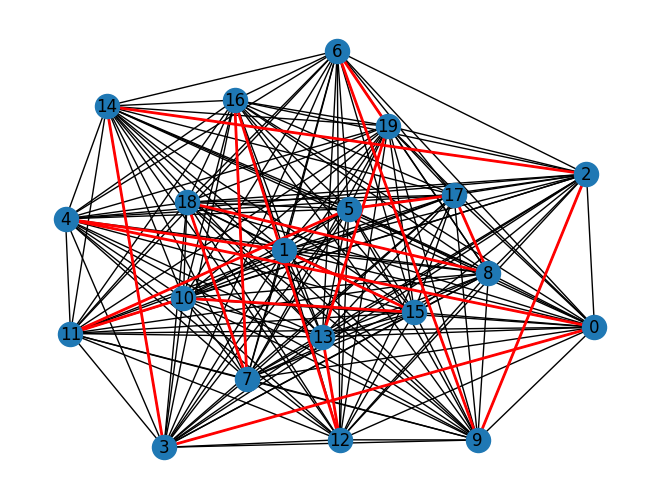

In [5]:
# See the actual pat
G, path = dummy[0] 
plt.figure()
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
path_edges = list(zip(path, path[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
plt.show()

In [6]:
print('path', path)
print(f"edge tour attributes {nx.get_edge_attributes(G, 'tour')}")
print(f"edge weight attributes {nx.get_edge_attributes(G, 'weight')}")
print(f"node pos attributes {nx.get_node_attributes(G, 'pos')}")

path [0, 3, 14, 2, 9, 6, 19, 13, 12, 16, 7, 18, 8, 17, 5, 11, 10, 15, 1, 4, 0]
edge tour attributes {(0, 1): 0, (0, 2): 0, (0, 3): 1, (0, 4): 1, (0, 5): 0, (0, 6): 0, (0, 7): 0, (0, 8): 0, (0, 9): 0, (0, 10): 0, (0, 11): 0, (0, 12): 0, (0, 13): 0, (0, 14): 0, (0, 15): 0, (0, 16): 0, (0, 17): 0, (0, 18): 0, (0, 19): 0, (1, 2): 0, (1, 3): 0, (1, 4): 1, (1, 5): 0, (1, 6): 0, (1, 7): 0, (1, 8): 0, (1, 9): 0, (1, 10): 0, (1, 11): 0, (1, 12): 0, (1, 13): 0, (1, 14): 0, (1, 15): 1, (1, 16): 0, (1, 17): 0, (1, 18): 0, (1, 19): 0, (2, 3): 0, (2, 4): 0, (2, 5): 0, (2, 6): 0, (2, 7): 0, (2, 8): 0, (2, 9): 1, (2, 10): 0, (2, 11): 0, (2, 12): 0, (2, 13): 0, (2, 14): 1, (2, 15): 0, (2, 16): 0, (2, 17): 0, (2, 18): 0, (2, 19): 0, (3, 4): 0, (3, 5): 0, (3, 6): 0, (3, 7): 0, (3, 8): 0, (3, 9): 0, (3, 10): 0, (3, 11): 0, (3, 12): 0, (3, 13): 0, (3, 14): 1, (3, 15): 0, (3, 16): 0, (3, 17): 0, (3, 18): 0, (3, 19): 0, (4, 5): 0, (4, 6): 0, (4, 7): 0, (4, 8): 0, (4, 9): 0, (4, 10): 0, (4, 11): 0, (4, 12): 0

(10 pts) Implement a dataset class. Focus on the getitem method to
return:
- X: A tensor of node coordinates with size 20 × 2.
- y: A tour starting from 0 and ending with 0.

In [7]:
dummy

[(<networkx.classes.graph.Graph at 0x7f565e68d450>,
  [0, 3, 14, 2, 9, 6, 19, 13, 12, 16, 7, 18, 8, 17, 5, 11, 10, 15, 1, 4, 0]),
 (<networkx.classes.graph.Graph at 0x7f565bbabcd0>,
  [0, 13, 4, 14, 18, 9, 16, 5, 19, 7, 6, 8, 2, 10, 12, 17, 11, 1, 15, 3, 0]),
 (<networkx.classes.graph.Graph at 0x7f5b67507890>,
  [0, 3, 19, 4, 10, 14, 1, 2, 6, 18, 13, 16, 12, 9, 5, 17, 15, 11, 7, 8, 0]),
 (<networkx.classes.graph.Graph at 0x7f5b6751c2d0>,
  [0, 3, 10, 16, 19, 11, 15, 12, 7, 14, 4, 17, 2, 1, 18, 9, 13, 5, 6, 8, 0]),
 (<networkx.classes.graph.Graph at 0x7f5b6751fdd0>,
  [0, 17, 19, 4, 16, 18, 3, 10, 7, 11, 12, 1, 8, 13, 6, 9, 14, 2, 5, 15, 0]),
 (<networkx.classes.graph.Graph at 0x7f5b67533910>,
  [0, 1, 4, 3, 13, 12, 6, 17, 5, 7, 11, 15, 19, 18, 14, 2, 10, 16, 9, 8, 0]),
 (<networkx.classes.graph.Graph at 0x7f5b6753f5d0>,
  [0, 1, 2, 11, 9, 12, 5, 3, 7, 19, 13, 15, 4, 8, 10, 14, 17, 18, 16, 6, 0]),
 (<networkx.classes.graph.Graph at 0x7f5b6754f110>,
  [0, 2, 14, 1, 6, 12, 11, 19, 5, 3, 1

In [8]:
from torch.utils.data import Dataset, DataLoader

class TSPDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        G, path = self.data[idx]
        node_pos = nx.get_node_attributes(G, 'pos')
        pos = [v for k,v in node_pos.items()]
        return torch.tensor(pos), torch.tensor(path)

ds = TSPDataset(dummy)
print(len(ds))
pos, tour = ds[0]
assert pos.shape == (20, 2)
assert tour[0] == 0 and tour[-1] == 0
print(pos.shape, tour.shape)
print(pos, tour)

100
torch.Size([20, 2]) torch.Size([21])
tensor([[0.6049, 0.5749],
        [0.3847, 0.9428],
        [0.6102, 0.3708],
        [0.5498, 0.5148],
        [0.5942, 0.6544],
        [0.0619, 0.4332],
        [0.7476, 0.3951],
        [0.6549, 0.0625],
        [0.2211, 0.2142],
        [0.6697, 0.4364],
        [0.3206, 0.7886],
        [0.3776, 0.4964],
        [0.8300, 0.3489],
        [0.9984, 0.2725],
        [0.5306, 0.4147],
        [0.2541, 0.8878],
        [0.7025, 0.2586],
        [0.1113, 0.3599],
        [0.3338, 0.1718],
        [0.8953, 0.6299]]) tensor([ 0,  3, 14,  2,  9,  6, 19, 13, 12, 16,  7, 18,  8, 17,  5, 11, 10, 15,
         1,  4,  0])


In [9]:
train = pickle.loads(open('data/train_20_DLL_ass4.pkl', 'rb').read())
valid = pickle.loads(open('data/valid_20_DLL_ass4.pkl', 'rb').read())
test = pickle.loads(open('data/test_20_DLL_ass4.pkl', 'rb').read())

train, valid, test = TSPDataset(train), TSPDataset(valid), TSPDataset(test)

len(train), len(valid), len(test)

train_dl = DataLoader(train, batch_size=4, shuffle=True)
valid_dl = DataLoader(valid, batch_size=4, shuffle=True)
valid_dl = DataLoader(test, batch_size=4, shuffle=True)

## Make sure batching and collation works as intended...
for sample in train_dl:
    break
pos, path = sample
print(pos.shape, path.shape)
print(pos, path)

torch.Size([4, 20, 2]) torch.Size([4, 21])
tensor([[[8.2292e-01, 3.0425e-01],
         [4.3008e-01, 8.9945e-01],
         [3.8127e-01, 4.6026e-01],
         [1.1408e-01, 1.0030e-01],
         [8.6969e-01, 2.5279e-03],
         [8.9233e-01, 1.2366e-01],
         [4.5736e-01, 7.9768e-01],
         [2.9592e-02, 9.8846e-01],
         [4.6930e-01, 8.3466e-02],
         [5.8475e-01, 8.9096e-01],
         [4.1078e-01, 6.6984e-01],
         [4.1073e-01, 4.0475e-01],
         [8.2821e-01, 8.6692e-01],
         [3.7448e-01, 1.6267e-01],
         [3.9771e-01, 3.1606e-01],
         [7.2873e-01, 7.2218e-01],
         [6.6316e-01, 3.7021e-01],
         [2.0587e-02, 5.4851e-01],
         [6.3497e-01, 1.7894e-01],
         [5.5469e-01, 8.7134e-01]],

        [[3.2790e-04, 2.0287e-01],
         [6.1626e-01, 5.7911e-01],
         [8.3704e-01, 7.4467e-01],
         [9.4347e-01, 8.5304e-01],
         [6.4971e-01, 6.6967e-01],
         [3.8413e-01, 1.1949e-01],
         [8.7256e-01, 5.2821e-01],
         [

## Model

In [10]:
class Model(nn.Module):
    def __init__(self, n_emb, nlayers, d_model=32, nhead=1 ):
        super().__init__()
        self.linear = nn.Linear(2, d_model)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True, activation=F.gelu),
            num_layers=nlayers,
        )

        self.enc2dec = nn.Linear(d_model, d_model) # dims are the same
        self.embedding = nn.Embedding(n_emb, d_model)
        self.pos_emb = nn.Parameter(torch.randn(1, n_emb, d_model))
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=d_model, nhead=1, batch_first=True, activation=F.gelu),
            num_layers=nlayers,
        )
        self.to_logits = nn.Linear(d_model, n_emb)

    def get_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x, y):
        # x [B, Nodes, 2]
        enc_embs = self.linear(x) # 
        # print('encs', enc_embs.shape)
        # enc_embs [B, Nodes, d_model]
        enc_out = self.encoder(enc_embs)
        # enc_out [N, Nodes, d_model]
        dec_qk = self.enc2dec(enc_out)

        # y [B, n_emb]
        dec_emb = self.embedding(y) 
        # dec_emb [B, n_emb, d_model]
        b, n, d = dec_emb.shape
        dec_emb += self.pos_emb[:, :n, :]
        # print("dec_emb.shape, dec_qk.shape", dec_emb.shape, dec_qk.shape)
        tgt_mask = self.get_mask(dec_emb.size(1)).to(x.device)
        dec_out = self.decoder(tgt = dec_emb, memory = dec_qk, tgt_mask=tgt_mask, tgt_is_causal=True)
        # print('dec_out.shape', dec_out.shape)
        # >>> memory = torch.rand(10, 32, 512)
        # >>> tgt = torch.rand(20, 32, 512)
        # >>> out = transformer_decoder(tgt, memory)
        logits = self.to_logits(dec_out)
        return logits

# pos, path
model = Model(n_emb=4, nlayers=4, d_model=32)
# model(torch.)
x = torch.tensor(
   [[0, 0],
    [0, 1],
    [1, 1],
    [1, 0]],
).float().reshape(1, 4, 2)
y = torch.tensor([
    [0, 1, 2, 3],
]).int().reshape(1, 4)

print(x.shape, y.shape)
x = model(x, y)
print(x.shape)

torch.Size([1, 4, 2]) torch.Size([1, 4])
torch.Size([1, 4, 4])


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


(10 pts) Explain where and why masking is used.

Answer: Masking is used in the decoder. 

Decoder is a essentially a causal model that predicts t+1 token from t tokens.
In order to "fairly" predict the next token, a causal mask is used in the attention layer
of the decoder. Causal mask is a triangular lower matrix (1 means that token can attend)
0 means not. 
To be more specific:
given sequence [0,1,2,3], the qkv projection layers encode
each token like so [e0, e1, e2, e4]. We have 3 tensors q, k and v. 
We first do q.T @ k, which essentially does an outer product between all ei embeddings.
It is at this point that we mutilply this (q.T @ k) * trilu. This means that q and k embeddings
Can only 'talk' with previous tokens. 

(5 pts) Explain why positional encoding may be omitted in the encoder.


Answer: We are passing in a graph node position information. Position information should 
not depend on ordering, just like the nodes of the graph should not depend on ordering.
Omitting PE layer means that encoder doesn't have a way to know positions of tokens.

(5 pts) Explain why positional encoding is necessary in the decoder.


Decoder is fed a path. Path is an ordered sequence of steps. Just like with words, 
rearranging words in a sequence might lead to errors. Therefore, the model
must know positions of the words. This is why we add PE to the path inputs to the decoder.

## Training

### Training WITHOUT gradient accumulation

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 32
model = Model(n_emb=20, nlayers=4, d_model=256, nhead=4)
model = model.to(device)

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
train_dl = DataLoader(train, batch_size=1024 * 4, shuffle=True)
valid_dl = DataLoader(valid, batch_size=512, shuffle=False)
test_dl = DataLoader(test,  batch_size=512, shuffle=False)

val_loss   = []
train_loss = []
for epoch in range(epochs):
    total_loss = torch.tensor(0.)
    pbar = tqdm(enumerate(train_dl), colour='green', total=len(train_dl), )
    for step, (pos, path) in pbar:
        optim.zero_grad()
        pos, path = pos.to(device), path.to(device)
        path_in =  path[:, :-1] # before last
        path_out = path[:, 1:] # after first
        logits = model(pos, path_in)
        loss = F.cross_entropy(
            logits.transpose(1, 2),
            path_out,
        )
        loss.backward()
        optim.step()
        total_loss += loss.item()
        pbar.set_description(f'loss {loss.item():.4f}')
    total_loss /= len(train_dl)
    train_loss.append(total_loss)

    with torch.no_grad():
        total_loss = torch.tensor(0.)
        for step, (pos, path) in enumerate(valid_dl):
            pos, path = pos.to(device), path.to(device)
            path_in =  path[:,:-1] # before last
            path_out = path[:, 1:] # after first
            logits = model(pos, path_in)
            total_loss += F.cross_entropy(
                logits.transpose(1, 2),
                path_out,
            ).item()
        total_loss /= len(valid_dl)
        print(f'val loss {total_loss:.4f}')
        val_loss.append(total_loss)

loss 2.8297: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


val loss 2.8136


loss 2.7312: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


val loss 2.7237


loss 2.5975: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


val loss 2.5900


loss 2.4426: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


val loss 2.4268


loss 2.2759: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


val loss 2.2678


loss 2.1609: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


val loss 2.1437


loss 2.0933: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


val loss 2.0891


loss 2.0544: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


val loss 2.0599


loss 2.0400: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


val loss 2.0430


loss 2.0331: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


val loss 2.0358


loss 2.0312: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


val loss 2.0331


loss 2.0242: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


val loss 2.0279


loss 2.0192: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


val loss 2.0245


loss 2.0144: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


val loss 2.0243


loss 2.0130: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


val loss 2.0222


loss 2.0170: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


val loss 2.0217


loss 2.0139: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


val loss 2.0180


loss 2.0132: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


val loss 2.0190


loss 2.0117: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


val loss 2.0171


loss 2.0139: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


val loss 2.0166


loss 2.0113: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


val loss 2.0174


loss 2.0102: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


val loss 2.0117


loss 2.0105: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


val loss 2.0145


loss 2.0044: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


val loss 2.0159


loss 2.0039: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


val loss 2.0137


loss 2.0017: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


val loss 2.0138


loss 1.9991: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


val loss 2.0114


loss 2.0015: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


val loss 2.0080


loss 2.0061: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


val loss 2.0112


loss 1.9989: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


val loss 2.0080


loss 1.9967: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


val loss 2.0102


loss 1.9990: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

val loss 2.0098


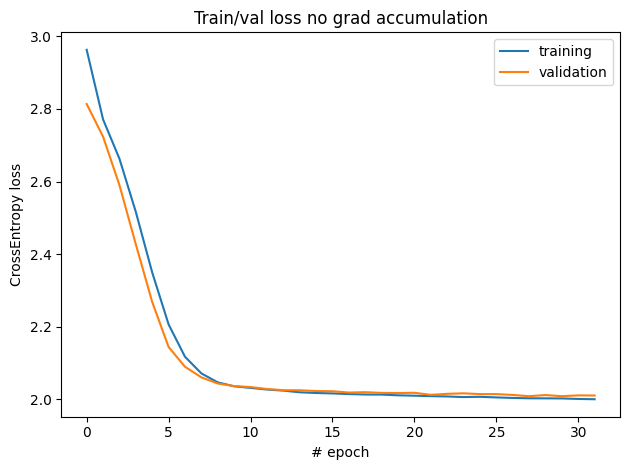

In [13]:
plt.figure()
plt.title("Train/val loss no grad accumulation")
plt.plot(range(epochs), train_loss, label='training')
plt.plot(range(epochs), val_loss, label='validation')
plt.xlabel('# epoch')
plt.ylabel('CrossEntropy loss')
plt.legend()
plt.tight_layout()
plt.savefig("loss_nograd.png", dpi=400)
plt.show()

In [14]:
torch.save(model.state_dict(), open('model_nograd.pt', 'wb'))

(10 pts) Explain the function transformer tsp, which uses the model you
trained to predict a tour. You should notice that it’s close to the greedy
sampling strategy we used in NLP task. Which is the main difference?

transformer_tsp generates a TSP path using a trained model. It starts by feeding in transformer an initial state
and then predicting most likely next step. We sample at most N state transitions greedily (with topk). And then calculate the total cost of 
the path made from transformer so far. Main difference is that we disallow revisiting the old states. 

### Training WITH gradient accumulation

In [16]:
epochs = 32
model = Model(n_emb=20, nlayers=4, d_model=256, nhead=4)
model = model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3) # Larger LR, since we see 
# less # updates and more effective batches x4
train_dl = DataLoader(train, batch_size=1024 * 4, shuffle=True)
valid_dl = DataLoader(valid, batch_size=512, shuffle=False)
test_dl = DataLoader(test,  batch_size=512, shuffle=False)

val_loss = []
train_loss = []

# Gradient accumulation steps
gradient_accumulation_steps = 4

for epoch in range(epochs):
    model.train()
    total_loss = torch.tensor(0.)
    pbar = tqdm(enumerate(train_dl), colour='green', total=len(train_dl))

    # Reset the optimizer at the start of each epoch
    optim.zero_grad()

    for step, (pos, path) in pbar:
        pos, path = pos.to(device), path.to(device)
        path_in = path[:, :-1]  # before last
        path_out = path[:, 1:]  # after first
        logits = model(pos, path_in)
        loss = F.cross_entropy(
            logits.transpose(1, 2),
            path_out,
        )

        # Normalize loss by accumulation steps and backpropagate
        loss = loss / gradient_accumulation_steps
        loss.backward()

        # Update weights after every accumulation step
        if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(train_dl):
            optim.step()
            optim.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps  # Undo normalization for logging
        pbar.set_description(f'loss {loss.item() * gradient_accumulation_steps:.4f}')

    total_loss /= len(train_dl)
    train_loss.append(total_loss.item())

    model.eval()
    with torch.no_grad():
        total_val_loss = torch.tensor(0.)
        for step, (pos, path) in enumerate(valid_dl):
            pos, path = pos.to(device), path.to(device)
            path_in = path[:, :-1]  # before last
            path_out = path[:, 1:]  # after first
            logits = model(pos, path_in)
            total_val_loss += F.cross_entropy(
                logits.transpose(1, 2),
                path_out,
            ).item()

        total_val_loss /= len(valid_dl)
        print(f'val loss {total_val_loss:.4f}')
        val_loss.append(total_val_loss.item())

  0%|          | 0/13 [00:00<?, ?it/s]

loss 3.2551: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


val loss 3.3436


loss 2.9150: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


val loss 2.8547


loss 2.8734: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


val loss 2.8592


loss 2.8260: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


val loss 2.8466


loss 2.8211: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


val loss 2.8186


loss 2.8174: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


val loss 2.8100


loss 2.8125: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


val loss 2.8050


loss 2.8097: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


val loss 2.8035


loss 2.8073: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


val loss 2.7998


loss 2.8094: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


val loss 2.8004


loss 2.8065: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


val loss 2.7983


loss 2.8056: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


val loss 2.7988


loss 2.8066: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


val loss 2.7979


loss 2.8053: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


val loss 2.7979


loss 2.8051: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


val loss 2.7976


loss 2.8047: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


val loss 2.7976


loss 2.8045: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


val loss 2.7974


loss 2.8047: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


val loss 2.7974


loss 2.8046: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


val loss 2.7974


loss 2.8037: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


val loss 2.7974


loss 2.8041: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


val loss 2.7973


loss 2.8025: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


val loss 2.7973


loss 2.8021: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


val loss 2.7973


loss 2.8031: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


val loss 2.7973


loss 2.8034: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


val loss 2.7973


loss 2.8043: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


val loss 2.7973


loss 2.8030: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


val loss 2.7973


loss 2.8027: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


val loss 2.7972


loss 2.8008: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


val loss 2.7972


loss 2.8008: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


val loss 2.7972


loss 2.8020: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


val loss 2.7972


loss 2.8008: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]

val loss 2.7972


In [25]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

11657236

In [17]:
torch.save(model.state_dict(), open('model.pt', 'wb'))

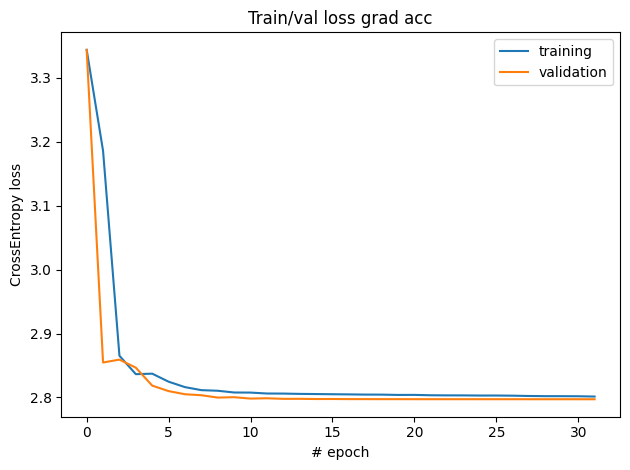

In [19]:
plt.figure()
plt.title("Train/val loss grad acc")
plt.plot(range(epochs), train_loss, label='training')
plt.plot(range(epochs), val_loss, label='validation')
plt.xlabel('# epoch')
plt.ylabel('CrossEntropy loss')
plt.legend()
plt.tight_layout()
plt.savefig("loss_grad.png", dpi=400)
plt.show()

## Testing

In [20]:
model_GA = Model(n_emb=20, nlayers=4, d_model=256, nhead=4)
model_GA.load_state_dict(torch.load(open('model.pt','rb'), map_location=device))
model_GA = model_GA.to(device)

model = Model(n_emb=20, nlayers=4, d_model=256, nhead=4)
model.load_state_dict(torch.load(open('model_nograd.pt','rb'), map_location=device))
model = model.to(device)

/tmp/ipykernel_5793/2629809984.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_GA.load_state_dict(torch.load(open('model.pt','rb'), map_location=device))
/tmp/ipyk

In [21]:
test = pickle.loads(open('data/test_20_DLL_ass4.pkl', 'rb').read())

results = []
for sample in tqdm(random.choices(test, k=20)):
    G, path = sample
    results.append(gap(G, model, model_GA=model_GA,  random_seed=42, device=device))
df = pd.DataFrame(results)

100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


In [22]:
df

greedy      random  transformer_tsp  transformer_tsp_acc_grad
0   21.915325  152.745933       157.036939                135.066600
1    6.330246  163.914135       214.220333                182.875009
2   18.551933  232.861386       215.653008                187.928569
3    3.229360  211.595870       157.769503                167.299160
4   27.574934  301.523497       246.999309                199.097642
5   16.661699   86.992984       126.482855                111.847432
6   10.966365  128.905445       234.120014                228.825281
7    4.037199  175.594184       231.501946                195.548668
8   35.961583  153.199773       208.160983                208.771310
9   13.669226  159.944215       121.647367                203.328338
10   2.974459  166.911349       161.352725                153.782248
11  22.001170  157.165433       151.330840                137.472440
12   0.083218  209.198722       240.475031                199.036424
13   5.027839  211.155508       142.870202                190.654780
14  22.597242  151.570243       200.765555                204.435379
15   9.779923  171.475655       191.014814                150.559510
16  15.545332  137.981856       153.376619                155.536949
17   2.568747  159.049363       115.029562                171.753825
18  16.276164  226.068685       188.320188                168.130590
19  26.492507  159.643639       131.145517                180.329804

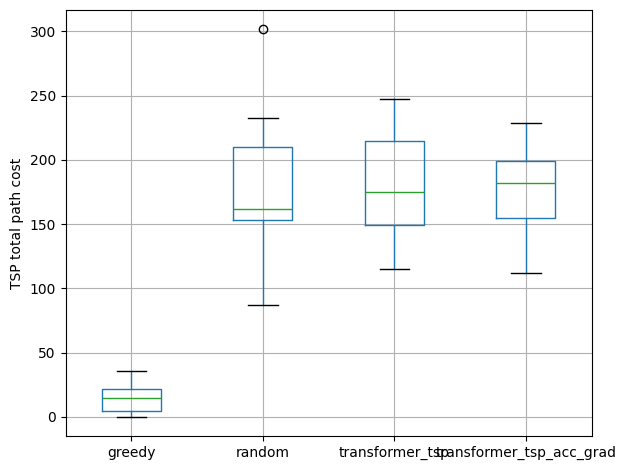

In [23]:
df.boxplot()
plt.ylabel('TSP total path cost')
plt.tight_layout()
plt.savefig('tsp_box.png')
plt.show()